In [258]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_Path = '/content/gdrive/MyDrive/Datasets/'
    model_Path = '/content/gdrive/MyDrive/models/'
except:
    dataset_Path = '/home/bilz/Datasets/'
    model_Path = '/home/bilz/models/'

datasetName = 'DeepIOD_Dataset.csv'
dataset_Path_DeepIOD = dataset_Path + datasetName
DATA_PATH = dataset_Path_DeepIOD
print(DATA_PATH)

/home/bilz/Datasets/DeepIOD_Dataset.csv


In [259]:
version = 1.5
window_size = 200
epoch_number = 200
batch_number = 64
fold_number = 6
input_features = 9
outputs_class = 2
modelNumber = 0

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
import time
import seaborn as sns
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc

In [261]:
# load the original CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)
print(df.head())

   Time  location_bearingAccuracy  location_speedAccuracy  \
0     0                      45.0                     1.5   
1     1                      45.0                     1.5   
2     2                      45.0                     1.5   
3     3                      45.0                     1.5   
4     4                      45.0                     1.5   

   location_verticalAccuracy  location_horizontalAccuracy  location_speed  \
0                   1.333717                       14.062             0.0   
1                   1.333717                       14.062             0.0   
2                   1.333717                       14.062             0.0   
3                   1.333717                       14.062             0.0   
4                   1.333717                       14.062             0.0   

   location_bearing  location_altitude  location_longitude  location_latitude  \
0               0.0               81.5          127.352635          36.364352   
1       

In [262]:
import pandas as pd

# Assuming df is your dataset

# Read data from CSV or any other source
data = pd.DataFrame(df)

print('Shape of the data:', data.shape)

# Converting the string formatted data into float dynamically
for col in data.columns[:-1]:  # Exclude the last column assuming it's the label
    data[col] = data[col].astype('float')

# Number of Frames
Fs = 20  

# Get the unique states from the label column
states = data.iloc[:, -1].value_counts().index

# Now all columns except the last one are converted to float


Shape of the data: (19182, 46)


/tmp/ipykernel_85852/1485986613.py:20: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])


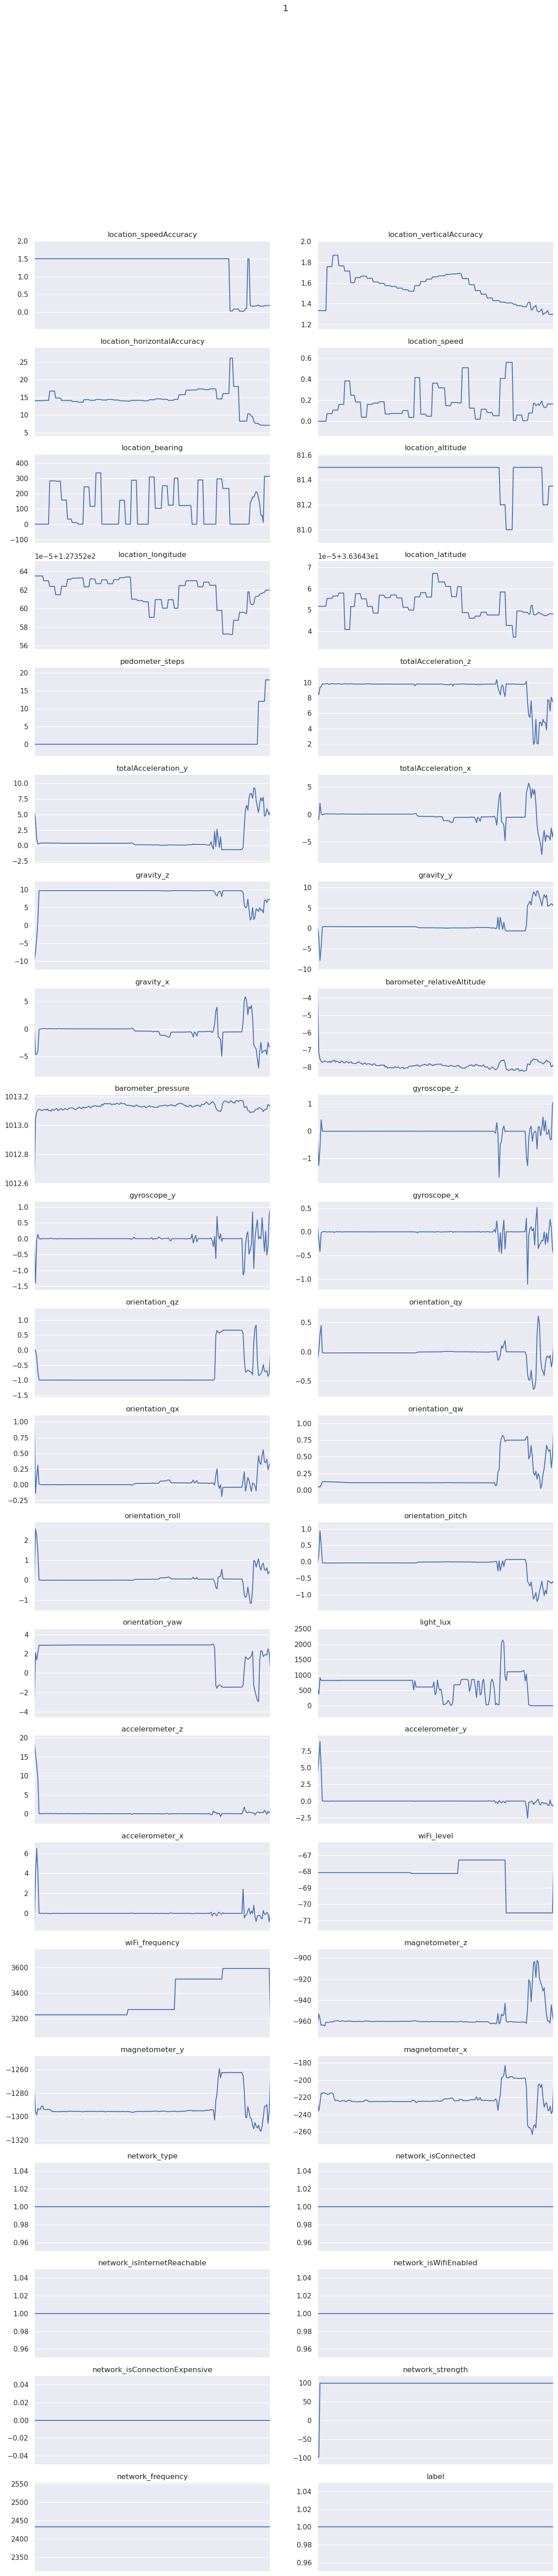

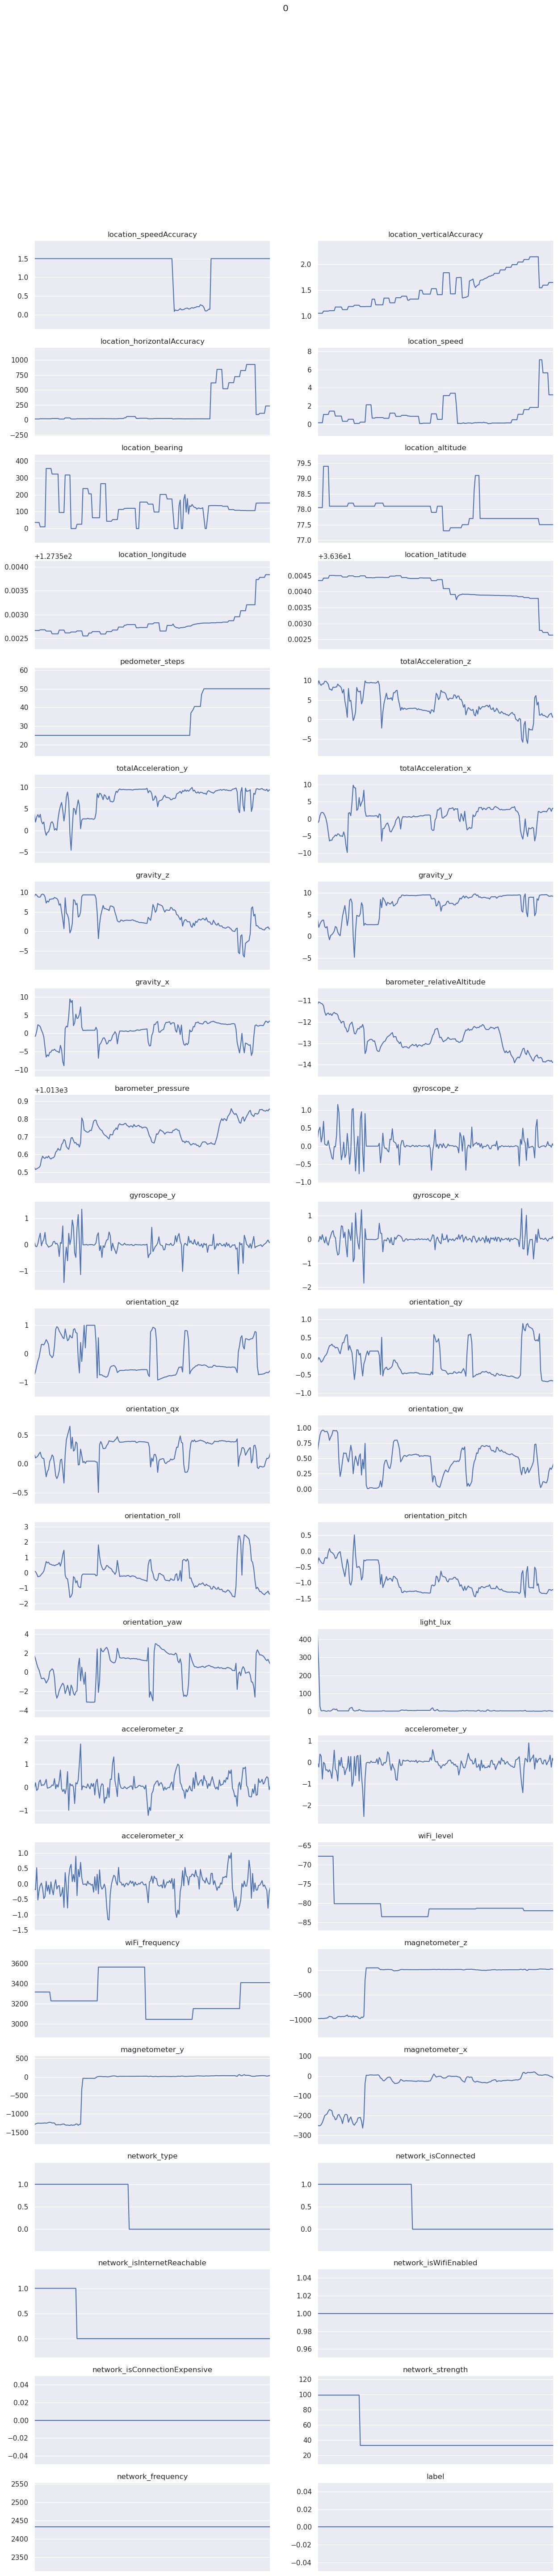

In [263]:
import matplotlib.pyplot as plt
import numpy as np

def plot_state(state, data):
    num_cols = len(data.columns) - 2  # Excluding 'index' and 'state' columns
    num_rows = (num_cols + 2 - 1) // 2  # Compute number of rows for subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, num_rows * 3), sharex=True)
    axes = axes.flatten()  # Flatten axes to simplify iteration
    for i, col in enumerate(data.columns[2:]):  # Exclude 'index' and 'state' columns
        plot_axis(axes[i], data['Time'], data[col], col)
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'b')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

# Assuming 'data' contains your dataset and 'states' contains unique states
for state in states:
    data_for_plot = data[data['label'] == state][:Fs*10]
    plot_state(state, data_for_plot)


### Balancing the Dataset

In [264]:
df = data.drop(['Time'], axis = 1).copy()
df['label'].value_counts()

label
1    12083
0     7099
Name: count, dtype: int64

/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


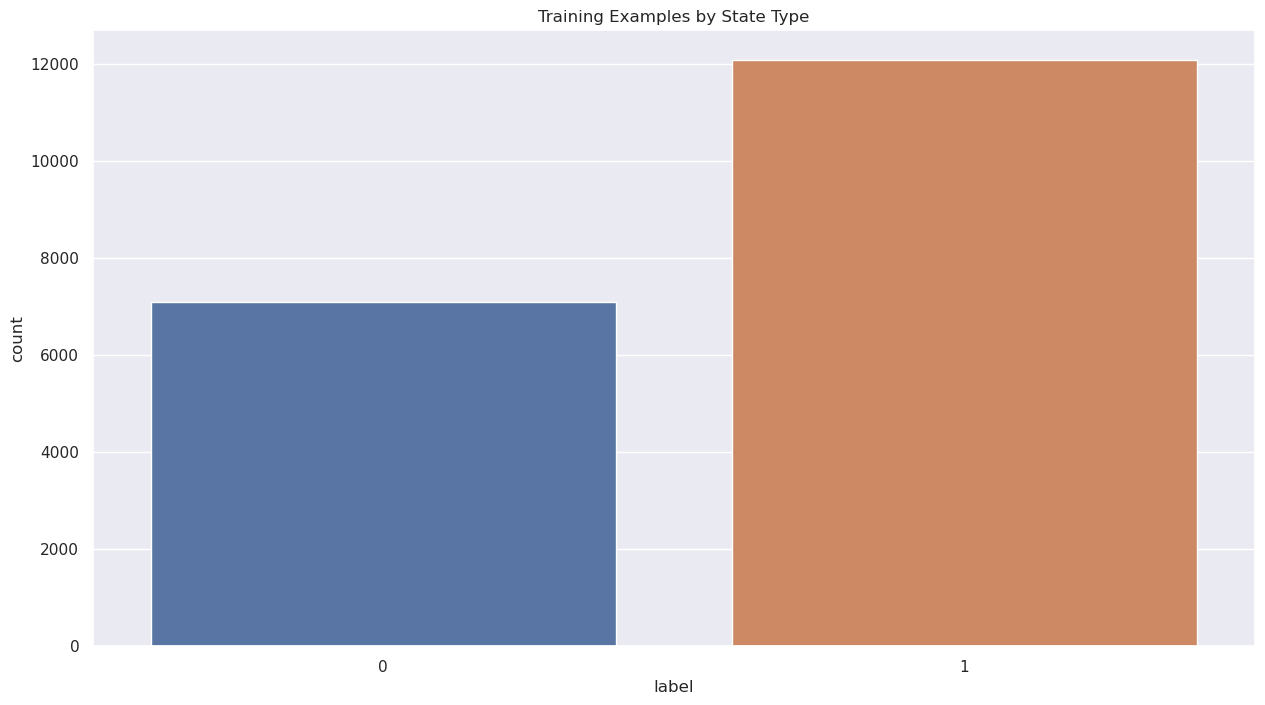

In [265]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'label', data = df)
plt.title('Training Examples by State Type')
plt.show()

### Now in the following:
#### We calculate the minimum count between the 'Outdoor' and 'Indoor' states using the min() function.
#### Then, we slice both dataframes to contain only the first min_count samples using .iloc[:min_count].
#### This ensures that both 'Outdoor' and 'Indoor' dataframes have an equal number of samples, capped to the smallest count between the two states.

In [266]:
# Filter data for 'Outdoor' and 'Indoor' states
Outdoor = df[df['label'] == 0].copy()
Indoor = df[df['label'] == 1].copy()

# Calculate the minimum count between 'Outdoor' and 'Indoor' states
min_count = min(len(Outdoor), len(Indoor))

# Cap the number of samples to the smallest count
Outdoor = Outdoor.iloc[:min_count].copy()
Indoor = Indoor.iloc[:min_count].copy()


In [267]:
try:
    balanced_data = pd.DataFrame()
    balanced_data = balanced_data.append([Outdoor, Indoor])
    balanced_data.shape
except:
    # Concatenate the DataFrames
    balanced_data = pd.concat([Outdoor, Indoor])

# Check the shape of the resulting DataFrame
print(balanced_data.shape)

(14198, 45)


In [268]:
from sklearn.preprocessing import StandardScaler

# Assuming 'balanced_data' contains your dataset with features and labels

# Extract features and labels
X = balanced_data.drop(columns=['label'])  # Extract all columns except the label column
y = balanced_data['label']  # Extract the label column

# Calculate the minimum count for each label
min_count = balanced_data['label'].value_counts().min()

# Balance the dataset by capping the number of samples for each label to the smallest count
balanced_data = balanced_data.groupby('label').head(min_count)

# Separate features and labels again
X = balanced_data.drop(columns=['label'])  # Extract all columns except the label column
y = balanced_data['label']  # Extract the label column

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with scaled features and labels
scaled_X = pd.DataFrame(data=X_scaled, columns=X.columns)
scaled_X['label'] = y.values

scaled_X


,location_bearingAccuracy,location_speedAccuracy,location_verticalAccuracy,location_horizontalAccuracy,location_speed,location_bearing,location_altitude,location_longitude,location_latitude,pedometer_steps,...,magnetometer_y,magnetometer_x,network_type,network_isConnected,network_isInternetReachable,network_isWifiEnabled,network_isConnectionExpensive,network_strength,network_frequency,label
0,0.587011,0.451079,-0.758577,-0.459776,-0.444550,-0.734502,-0.351304,-1.024992,-0.744025,-0.781541,...,-5.504210,-0.941552,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,-0.85249,0
1,0.587011,0.451079,-0.758577,-0.459776,-0.444550,-0.734502,-0.351304,-1.024992,-0.744025,-0.781541,...,-5.409210,-0.950997,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,-0.85249,0
2,0.587011,0.451079,-0.758577,-0.459776,-0.444550,-0.734502,-0.351304,-1.024992,-0.744025,-0.781541,...,-5.350733,-0.949038,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,-0.85249,0
3,0.587011,0.451079,-0.758577,-0.459776,-0.444550,-0.734502,-0.351304,-1.024992,-0.744025,-0.781541,...,-5.317169,-0.932337,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,-0.85249,0
4,0.587011,0.451079,-0.758577,-0.459776,-0.444550,-0.734502,-0.351304,-1.024992,-0.744025,-0.781541,...,-5.319485,-0.898198,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,-0.85249,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14193,0.587011,0.451079,-0.714256,-0.464483,-0.161185,-0.480490,1.023101,0.982691,1.094874,-0.866465,...,-0.053067,-0.288326,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,0.81437,1
14194,0.587011,0.451079,-0.714256,-0.464483,-0.161185,-0.480490,1.023101,0.982691,1.094874,-0.866465,...,-0.053496,-0.290672,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,0.81437,1
14195,0.587011,0.451079,-0.714256,-0.464483,-0.161185,-0.480490,1.023101,0.982691,1.094874,-0.866465,...,-0.053555,-0.290045,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,0.81437,1
14196,0.587011,0.451079,-0.714256,-0.464483,-0.161185,-0.480490,1.023101,0.982691,1.094874,-0.866465,...,-0.053795,-0.290348,1.215485,1.215485,1.27929,0.0,0.281139,0.800443,0.81437,1


In [269]:
# Displaying the balanced data
print('Label Count:',balanced_data['label'].value_counts())

Label Count: label
0    7099
1    7099
Name: count, dtype: int64


/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


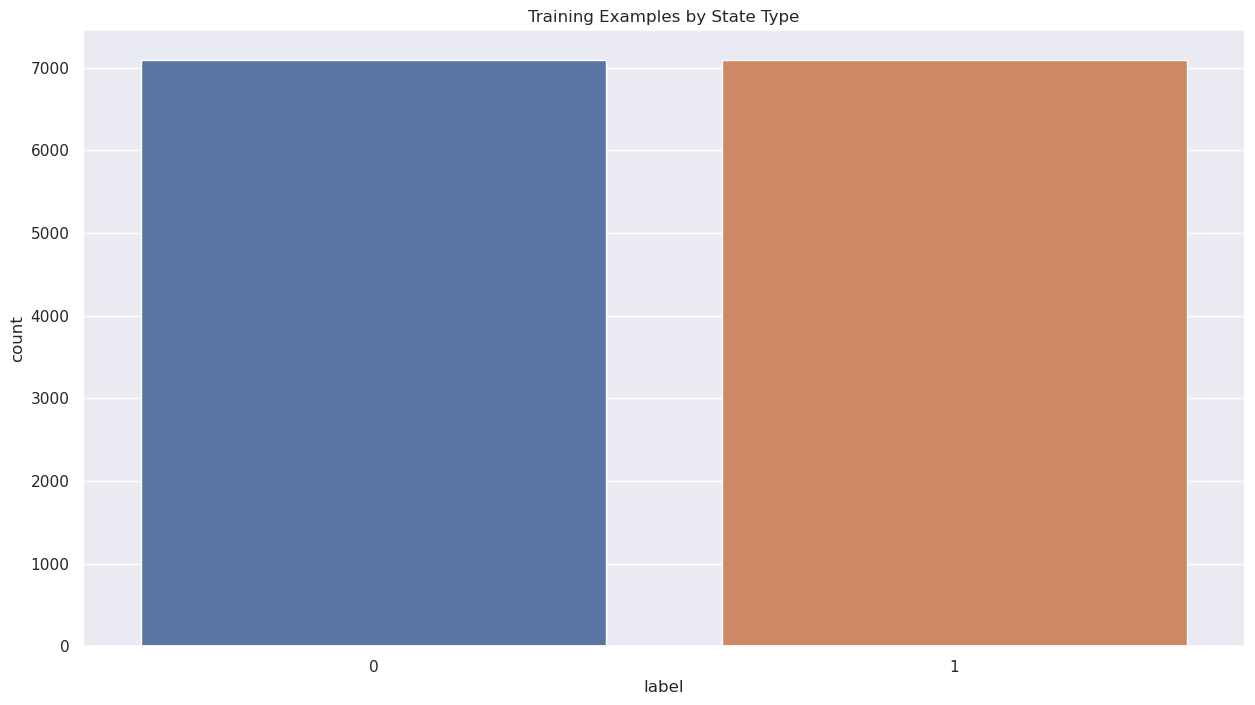

In [270]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'label', data = balanced_data)
plt.title('Training Examples by State Type')
plt.show()

In [271]:
# Encoding the Data with suitable labels
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['label'])
balanced_data.head()

,location_bearingAccuracy,location_speedAccuracy,location_verticalAccuracy,location_horizontalAccuracy,location_speed,location_bearing,location_altitude,location_longitude,location_latitude,pedometer_steps,...,magnetometer_y,magnetometer_x,network_type,network_isConnected,network_isInternetReachable,network_isWifiEnabled,network_isConnectionExpensive,network_strength,network_frequency,label
305,45.0,1.5,1.053023,13.235,0.155597,36.146122,78.055546,127.352668,36.364347,25.0,...,-1295.366219,-248.999994,1.0,1.0,1.0,1.0,0.0,99.0,2432.0,0
306,45.0,1.5,1.053023,13.235,0.155597,36.146122,78.055546,127.352668,36.364347,25.0,...,-1272.843513,-251.978818,1.0,1.0,1.0,1.0,0.0,99.0,2432.0,0
307,45.0,1.5,1.053023,13.235,0.155597,36.146122,78.055546,127.352668,36.364347,25.0,...,-1258.979966,-251.361170,1.0,1.0,1.0,1.0,0.0,99.0,2432.0,0
308,45.0,1.5,1.053023,13.235,0.155597,36.146122,78.055546,127.352668,36.364347,25.0,...,-1251.022469,-246.093745,1.0,1.0,1.0,1.0,0.0,99.0,2432.0,0
309,45.0,1.5,1.053023,13.235,0.155597,36.146122,78.055546,127.352668,36.364347,25.0,...,-1251.571734,-235.327053,1.0,1.0,1.0,1.0,0.0,99.0,2432.0,0


### Standardizing the Dataset

In [272]:
import numpy as np
import pandas as pd

# Define the get_frames function
def get_frames(df, frame_size, hop_size, feature_columns, label_column):
    N_FEATURES = len(feature_columns)

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        frame = []
        for col in feature_columns:
            frame.append(df[col].values[i: i + frame_size])
        
        # Retrieve the most common label in this segment
        label = df[label_column][i + frame_size - 1]  # Assuming label is at the end of the frame
        frames.append(frame)
        labels.append(label)

    # Convert lists to numpy arrays
    frames = np.asarray(frames)
    labels = np.asarray(labels)

    return frames, labels

# Assuming you have already defined scaled_X DataFrame and get_frames function

# Replace infinite values with NaN
scaled_X = scaled_X.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
scaled_X = scaled_X.dropna()

# Reset index after dropping rows
scaled_X = scaled_X.reset_index()

# Set parameters
#window_size = 100  # Adjust window size as needed
Fs = window_size
frame_size = window_size
hop_size = int(window_size / 3)

# Get feature columns dynamically
feature_columns = scaled_X.columns[scaled_X.columns != 'label'].tolist()

# Call the get_frames function
X, y = get_frames(scaled_X, frame_size, hop_size, feature_columns, 'label')

# Output the shapes of X and y
X.shape, y.shape


((213, 45, 200), (213,))

In [273]:
# Call the get_frames function
X, y = get_frames(scaled_X, frame_size, hop_size, feature_columns, 'label')

# Transpose X array to have shape (428, 100, 44)
X = X.transpose(0, 2, 1)

# Output the shapes of X and y
X.shape, y.shape


((213, 200, 45), (213,))

In [274]:
scaled_X.shape

(14198, 46)

In [275]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating the K-fold cross-validation iterator
kfold = StratifiedKFold(n_splits=fold_number, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Shape of X: (213, 200, 45)
Shape of y: (213,)


((170, 200, 45), (43, 200, 45), (170,), (43,))

In [276]:
from keras.layers import Input


n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = outputs_class
input_shape=(n_timesteps,n_features)
inputs = Input(shape=input_shape)

print("input_shape = ",input_shape)
print("n_outputs = ",n_outputs)

input_shape =  (200, 45)
n_outputs =  2


### Propose Model

In [277]:
# Define the IODNET Heavy model
def IODNET_Heavy(input_shape, n_outputs):
    inputs = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x1 = LayerNormalization()(x1)
    x1 = MultiHeadAttention(num_heads=8, key_dim=64)(x1, x1)
    x1 = Dropout(0.2)(x1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(2, padding='same')(x1)  # Adjust pool size and add padding='same'
    x1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x1)
    x1 = LayerNormalization()(x1)
    x1 = MultiHeadAttention(num_heads=8, key_dim=64)(x1, x1)
    x1 = Dropout(0.2)(x1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(2, padding='same')(x1)  # Adjust pool size and add padding='same'
    x1 = GlobalAveragePooling1D()(x1)  # Reduce dimensionality
    x1 = Reshape((-1, 64))(x1)  # Reshape to (None, sequence_length, input_dim)

    # Decoder
    x2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x1)
    x2 = LayerNormalization()(x2)
    x2 = MultiHeadAttention(num_heads=8, key_dim=32)(x2, x2)
    x2 = Dropout(0.2)(x2)
    x2 = LayerNormalization()(x2)
    x2 = MaxPooling1D(2, padding='same')(x2)  # Adjust pool size and add padding='same'
    x2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x2)
    x2 = LayerNormalization()(x2)
    x2 = MultiHeadAttention(num_heads=8, key_dim=32)(x2, x2)
    x2 = Dropout(0.2)(x2)
    x2 = LayerNormalization()(x2)
    x2 = MaxPooling1D(2, padding='same')(x2)  # Adjust pool size and add padding='same'
    x2 = GlobalAveragePooling1D()(x2)  # Reduce dimensionality
    x2 = Reshape((-1, 32))(x2)  # Reshape to (None, sequence_length, input_dim)

    # Concatenate the outputs from both branches
    x = concatenate([x1, x2])

    # Output
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(n_outputs, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [278]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, DepthwiseConv2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate

# Define the 2D CNN model with Depth-wise Separable convolutions
def create_2d_cnn_depthwise(input_shape, n_outputs):
    model = Sequential()
    model.add(DepthwiseConv2D(3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(DepthwiseConv2D(3, padding='same', activation='relu'))
    model.add(Conv2D(32, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(DepthwiseConv2D(3, padding='same', activation='relu'))
    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(DepthwiseConv2D(3, padding='same', activation='relu'))
    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(n_outputs, activation='softmax'))
    
    return model

# Define the IODNET Light model with Depth-wise Separable convolutions
def IODNET_Depthwise(input_shape, n_outputs):
    inputs = Input(shape=input_shape)

    # 2D CNN branch
    cnn_model = create_2d_cnn_depthwise(input_shape, n_outputs)
    cnn_output = cnn_model(inputs)

    # Fully connected layers
    x = Dense(64, activation='relu')(cnn_output)
    x = Dropout(0.2)(x)

    outputs = Dense(n_outputs, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model




In [279]:
# Define the IODNET Light model

def IODNET_Light(input_shape, n_outputs):
    inputs = Input(shape=input_shape)

    # First 1D CNN branch
    x1 = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x1 = MaxPooling1D(2)(x1)
    x1 = LSTM(64)(x1)

    # Second 1D CNN branch
    x2 = Conv1D(64, kernel_size=5, activation='relu')(inputs)
    x2 = MaxPooling1D(2)(x2)
    x2 = LSTM(64)(x2)

    # Concatenate the outputs from both branches
    x = concatenate([x1, x2])

    x = Dropout(0.2)(x)
    outputs = Dense(n_outputs, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [280]:
# Define the IODNET Light model

def IODNET(input_shape, n_outputs):
    if modelNumber:
        if modelNumber == 1:
            return IODNET_Heavy(input_shape, n_outputs)
        else:
            # Create the IODNET Light model with Depth-wise Separable convolutions
            model = IODNET_Depthwise(input_shape, n_outputs)
            # Print model summary
            model.summary()
            return model

    else:
        return IODNET_Light(input_shape, n_outputs)


### Training 

In [281]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
import time

def trainingModel(model_path, X, y, X_test, y_test, fold_number=6, epoch_number=100, batch_number=64):
    kfold = KFold(n_splits=fold_number, shuffle=True)
    
    fold_test_acc = []
    fold_test_f1 = []
    fold_training_times = []
    best_test_acc = -1
    best_model = None

    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        print(f"Fold {fold+1}:")

        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Define the filepath for the saved model specific to this fold
        filepath = model_Path + f"bestModel_DeepIOD_D_{datasetName}_M{modelNumber}_V{version}_W_{window_size}_F_{fold+1}.h5"

        # Define early stopping based on validation loss
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        # Define a checkpoint to monitor the validation accuracy and save the best model
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        # Reshape input data if modelNumber is 2
        if modelNumber == 2:
            X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], X_train_fold.shape[2], 1)
            X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], X_val_fold.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

        input_shape = X_train_fold[0].shape
        model = IODNET(input_shape, outputs_class)
        optimizer = Adam(learning_rate=0.0001)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(X_train_fold, y_train_fold, epochs=epoch_number, batch_size=batch_number,
                            validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop], verbose=1)
        end_time = time.time()
        training_time = end_time - start_time

        fold_training_times.append(training_time)

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print("Validation Accuracy:", val_accuracy)

        # Load the best model for this fold
        best_fold_model = load_model(filepath)

        # Evaluate the best model on the test set
        test_loss, test_accuracy = best_fold_model.evaluate(X_test, y_test, verbose=0)
        print("Test Accuracy (Fold {}):".format(fold+1), test_accuracy)
        print(f"Accuracy: {test_accuracy}")

        test_pred = best_fold_model.predict(X_test)
        test_pred_labels = np.argmax(test_pred, axis=1)
        if len(y_test.shape) > 1 and y_test.shape[1] > 1:
            # Convert one-hot encoded labels to categorical labels
            test_true_labels = np.argmax(y_test, axis=1)
        else:
            # If y_test is already categorical labels, use it directly
            test_true_labels = y_test
        test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
        print(f"F1-score: {test_f1}")

        # Calculate the prediction time
        start_time = time.time()
        best_fold_model.predict(X_test[:1])
        end_time = time.time()
        prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds
        print(f"Mean Prediction Time (sec): {prediction_time:.6f}")
        print(f"Median Prediction Time (sec): {prediction_time:.6f}")
        print(f"Mean Single Prediction Time (msec): {prediction_time:.3f}")
        print(f"Median Single Prediction Time (msec): {prediction_time:.3f}")

        fold_test_acc.append(test_accuracy)
        fold_test_f1.append(test_f1)

        # Update best model if current model performs better
        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            best_model = best_fold_model

    mean_training_time = np.mean(fold_training_times)
    print(f"Mean Training Time (sec): {mean_training_time:.6f}")
    median_training_time = mean_training_time
    print(f"Median Training Time (sec): {mean_training_time:.6f}")

    # Save the best model after all folds
    best_model_path = model_Path + f"bestModel_DeepIOD_D_{datasetName}_M{modelNumber}_V{version}_W_{window_size}.h5"
    best_model.save(best_model_path)

    # Calculate the total number of parameters
    total_params = best_model.count_params()
    # Convert the total number of parameters to kilobytes (KB)
    total_params_kb = total_params / 1024  # 1 KB = 1024 bytes
    # Convert the total number of parameters to megabytes (MB)
    total_memory_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 precision (4 bytes per parameter)

    print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
    print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
    print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
    print(f"Median Model Parameters (K): {total_params_kb:.2f}")

    return best_model, best_test_acc, fold_test_acc, fold_test_f1, prediction_time, prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb
    


In [282]:
# Train the model and get the required outputs
modelNumber = 0 
trained_model, best_test_acc, test_acc, test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb = trainingModel(model_Path, X_train, y_train, X_test, y_test)
print("Test Accuracy is ", best_test_acc)



Fold 1:
Epoch 1/100


3/3 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.4894
Epoch 1: val_accuracy improved from -inf to 0.55172, saving model to /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M0_V1.5_W_200_F_1.h5
3/3 [==============================] - 2s 228ms/step - loss: 0.7743 - accuracy: 0.4894 - val_loss: 0.6834 - val_accuracy: 0.5517
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.7382 - accuracy: 0.5319
Epoch 2: val_accuracy improved from 0.55172 to 0.62069, saving model to /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M0_V1.5_W_200_F_1.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.7382 - accuracy: 0.5319 - val_loss: 0.6714 - val_accuracy: 0.6207
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.5390
Epoch 3: val_accuracy improved from 0.62069 to 0.68966, saving model to /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M0_V1.5_W_200_F_1.h5
3/3 [=====================

In [283]:
print(f"Accuracy: {test_acc}")
print(f"F1-score: {test_f1}")
print(f"Mean Prediction Time (sec): {mean_prediction_time:.6f}")
print(f"Median Prediction Time (sec): {median_prediction_time:.6f}")
print(f"Mean Training Time (sec): {mean_training_time:.6f}")
print(f"Median Training Time (sec): {median_training_time:.6f}")
print(f"Mean Single Prediction Time (msec): {mean_prediction_time * 1000:.3f}")
print(f"Median Single Prediction Time (msec): {median_prediction_time * 1000:.3f}")
print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
print(f"Median Model Parameters (K): {total_params_kb:.2f}")

Accuracy: [1.0, 1.0, 0.8139534592628479, 0.9069767594337463, 0.4883720874786377, 0.6744186282157898]
F1-score: [1.0, 1.0, 0.8063769335999158, 0.9063700707785642, 0.32049418604651164, 0.632317562149158]
Mean Prediction Time (sec): 31.058311
Median Prediction Time (sec): 31.058311
Mean Training Time (sec): 8.481766
Median Training Time (sec): 8.481766
Mean Single Prediction Time (msec): 31058.311
Median Single Prediction Time (msec): 31058.311
Mean Required Memory (Mb): 0.3413
Median Required Memory (Mb): 0.3413
Mean Model Parameters (K): 87.38
Median Model Parameters (K): 87.38


In [284]:
modelNumber = 1 
trained_model, best_test_acc, test_acc, test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb = trainingModel(model_Path, X_train, y_train, X_test, y_test)
print("Test Accuracy is ", best_test_acc)


Fold 1:
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.0773 - accuracy: 0.4894
Epoch 1: val_accuracy improved from -inf to 0.48276, saving model to /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M1_V1.5_W_200_F_1.h5
3/3 [==============================] - 4s 446ms/step - loss: 1.0773 - accuracy: 0.4894 - val_loss: 0.8607 - val_accuracy: 0.4828
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.5532
Epoch 2: val_accuracy did not improve from 0.48276
3/3 [==============================] - 1s 285ms/step - loss: 0.7031 - accuracy: 0.5532 - val_loss: 1.0541 - val_accuracy: 0.4828
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.7604 - accuracy: 0.5248
Epoch 3: val_accuracy did not improve from 0.48276
3/3 [==============================] - 1s 285ms/step - loss: 0.7604 - accuracy: 0.5248 - val_loss: 0.7355 - val_accuracy: 0.4828
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.7707 - 

In [ ]:
print(f"Accuracy: {test_acc}")
print(f"F1-score: {test_f1}")
print(f"Mean Prediction Time (sec): {mean_prediction_time:.6f}")
print(f"Median Prediction Time (sec): {median_prediction_time:.6f}")
print(f"Mean Training Time (sec): {mean_training_time:.6f}")
print(f"Median Training Time (sec): {median_training_time:.6f}")
print(f"Mean Single Prediction Time (msec): {mean_prediction_time * 1000:.3f}")
print(f"Median Single Prediction Time (msec): {median_prediction_time * 1000:.3f}")
print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
print(f"Median Model Parameters (K): {total_params_kb:.2f}")

Accuracy: [0.9069767594337463, 0.895348846912384, 0.5, 0.5, 0.9069767594337463, 0.5348837375640869]
F1-score: [0.9069264069264069, 0.8953346855983774, 0.3333333333333333, 0.3333333333333333, 0.9065217391304348, 0.4064872325741891]
Mean Prediction Time (sec): 39.440393
Median Prediction Time (sec): 39.440393
Mean Training Time (sec): 45.618973
Median Training Time (sec): 45.618973
Mean Single Prediction Time (msec): 39440.393
Median Single Prediction Time (msec): 39440.393
Mean Required Memory (Mb): 1.3877
Median Required Memory (Mb): 1.3877
Mean Model Parameters (K): 355.25
Median Model Parameters (K): 355.25


In [ ]:
modelNumber = 2 
trained_model, best_test_acc, test_acc, test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb = trainingModel(model_Path, X_train, y_train, X_test, y_test)
print("Test Accuracy is ", best_test_acc)


Fold 1:


Model: "model_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_130 (InputLayer)      [(None, 100, 45, 1)]      0         
                                                                 
 sequential_31 (Sequential)  (None, 2)                 18035436  
                                                                 
 dense_375 (Dense)           (None, 64)                192       
                                                                 
 dropout_1114 (Dropout)      (None, 64)                0         
                                                                 
 dense_376 (Dense)           (None, 2)                 130       
                                                                 
Total params: 18,035,758
Trainable params: 18,034,350
Non-trainable params: 1,408
_________________________________________________________________
Epoch 1/100
5/5 [========================

In [ ]:
print(f"Accuracy: {test_acc}")
print(f"F1-score: {test_f1}")
print(f"Mean Prediction Time (sec): {mean_prediction_time:.6f}")
print(f"Median Prediction Time (sec): {median_prediction_time:.6f}")
print(f"Mean Training Time (sec): {mean_training_time:.6f}")
print(f"Median Training Time (sec): {median_training_time:.6f}")
print(f"Mean Single Prediction Time (msec): {mean_prediction_time * 1000:.3f}")
print(f"Median Single Prediction Time (msec): {median_prediction_time * 1000:.3f}")
print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
print(f"Median Model Parameters (K): {total_params_kb:.2f}")

Accuracy: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1-score: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Mean Prediction Time (sec): 32.694578
Median Prediction Time (sec): 32.694578
Mean Training Time (sec): 39.782351
Median Training Time (sec): 39.782351
Mean Single Prediction Time (msec): 32694.578
Median Single Prediction Time (msec): 32694.578
Mean Required Memory (Mb): 68.8010
Median Required Memory (Mb): 68.8010
Mean Model Parameters (K): 17613.04
Median Model Parameters (K): 17613.04


### Multi-Voter Transformer (MVT) A Novel Encoder Architecture with Triple Attention and Majority Voting

In [ ]:
import keras
from keras import layers

def MVT(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Triple Encoders
    encoders_outputs = []
    for i in range(3):
        # Attention and Normalization
        encoder_input = inputs if i == 0 else encoders_outputs[i-1]
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(encoder_input, encoder_input)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + encoder_input

        # Feed Forward Part
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        encoders_outputs.append(x + res)

    # Majority Voter (Decoder)
    voter_input = layers.Concatenate(axis=2)(encoders_outputs)
    voter_input = layers.Dense(inputs.shape[-1], activation='relu')(voter_input)
    voter_output = layers.Dense(inputs.shape[-1], activation='softmax')(voter_input)

    # Updating Encoders
    updated_encoders_outputs = []
    for i in range(3):
        x = layers.Add()([voter_output, encoders_outputs[i]])
        updated_encoders_outputs.append(x)

    return updated_encoders_outputs, voter_output

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    n_classes,  
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        encoders_outputs, _ = MVT(x, head_size, num_heads, ff_dim, dropout)
        x = layers.Concatenate(axis=2)(encoders_outputs)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
import keras
from keras import layers

def MVT(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Triple Encoders
    encoders_outputs = []
    for i in range(3):
        # Attention and Normalization
        encoder_input = inputs if i == 0 else encoders_outputs[i-1]
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(encoder_input, encoder_input)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + encoder_input

        # Feed Forward Part
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        encoders_outputs.append(x + res)

    # Majority Voter (Decoder)
    voter_input = layers.Concatenate(axis=2)(encoders_outputs)
    voter_input = layers.Dense(inputs.shape[-1], activation='relu')(voter_input)
    voter_output = layers.Dense(inputs.shape[-1], activation='softmax')(voter_input)

    # Updating Encoders
    updated_encoders_outputs = []
    for i in range(3):
        x = layers.Add()([voter_output, encoders_outputs[i]])
        updated_encoders_outputs.append(x)

    return updated_encoders_outputs, voter_output

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    n_classes,  
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        encoders_outputs, _ = MVT(x, head_size, num_heads, ff_dim, dropout)
        x = layers.Concatenate(axis=2)(encoders_outputs)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
import time

def trainingModel(model_path, X, y, X_test, y_test, fold_number=6, epoch_number=100, batch_number=64):
    kfold = KFold(n_splits=fold_number, shuffle=True)
    
    fold_test_acc = []
    fold_test_f1 = []
    fold_training_times = []
    best_test_acc = -1
    best_model = None

    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        print(f"Fold {fold+1}:")

        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Define the filepath for the saved model specific to this fold
        filepath = model_path + f"bestModel_DeepIOD_D_{datasetName}_M{modelNumber}_V{version}_W_{window_size}_F_{fold+1}.h5"

        # Define early stopping based on validation loss
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        # Define a checkpoint to monitor the validation accuracy and save the best model
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        # Reshape input data if modelNumber is 2
        if modelNumber == 2:
            X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], X_train_fold.shape[2], 1)
            X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], X_val_fold.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

        input_shape = X_train_fold[0].shape
        # model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, n_classes)
        model = build_model(
        input_shape=input_shape,  
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        n_classes=outputs_class,  
        dropout=0.25,
    )
        
        optimizer = Adam(learning_rate=0.0001)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(X_train_fold, y_train_fold, epochs=epoch_number, batch_size=batch_number,
                            validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop], verbose=1)
        end_time = time.time()
        training_time = end_time - start_time

        fold_training_times.append(training_time)

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print("Validation Accuracy:", val_accuracy)

        # Load the best model for this fold
        best_fold_model = load_model(filepath)

        # Evaluate the best model on the test set
        test_loss, test_accuracy = best_fold_model.evaluate(X_test, y_test, verbose=0)
        print("Test Accuracy (Fold {}):".format(fold+1), test_accuracy)
        print(f"Accuracy: {test_accuracy}")

        test_pred = best_fold_model.predict(X_test)
        test_pred_labels = np.argmax(test_pred, axis=1)
        if len(y_test.shape) > 1 and y_test.shape[1] > 1:
            # Convert one-hot encoded labels to categorical labels
            test_true_labels = np.argmax(y_test, axis=1)
        else:
            # If y_test is already categorical labels, use it directly
            test_true_labels = y_test
        test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
        print(f"F1-score: {test_f1}")

        # Calculate the prediction time
        start_time = time.time()
        best_fold_model.predict(X_test[:1])
        end_time = time.time()
        prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds
        print(f"Mean Prediction Time (sec): {prediction_time:.6f}")
        print(f"Median Prediction Time (sec): {prediction_time:.6f}")
        print(f"Mean Single Prediction Time (msec): {prediction_time:.3f}")
        print(f"Median Single Prediction Time (msec): {prediction_time:.3f}")

        fold_test_acc.append(test_accuracy)
        fold_test_f1.append(test_f1)

        # Update best model if current model performs better
        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            best_model = best_fold_model

    mean_training_time = np.mean(fold_training_times)
    print(f"Mean Training Time (sec): {mean_training_time:.6f}")
    median_training_time = mean_training_time
    print(f"Median Training Time (sec): {mean_training_time:.6f}")

    # Save the best model after all folds
    best_model_path = model_path + f"bestModel_DeepIOD_D_{datasetName}_M{modelNumber}_V{version}_W_{window_size}.h5"
    best_model.save(best_model_path)

    # Calculate the total number of parameters
    total_params = best_model.count_params()
    # Convert the total number of parameters to kilobytes (KB)
    total_params_kb = total_params / 1024  # 1 KB = 1024 bytes
    # Convert the total number of parameters to megabytes (MB)
    total_memory_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 precision (4 bytes per parameter)

    print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
    print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
    print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
    print(f"Median Model Parameters (K): {total_params_kb:.2f}")

    return best_model, best_test_acc, fold_test_acc, fold_test_f1, prediction_time, prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb


In [ ]:
modelNumber = 3 
trained_model, best_test_acc, test_acc, test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb = trainingModel(model_Path, X_train, y_train, X_test, y_test)
print("Test Accuracy is ", best_test_acc)



Fold 1:
Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 2551.5269 - accuracy: 0.4772
Epoch 1: val_accuracy improved from -inf to 0.42105, saving model to /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M3_V1.4_W_100_F_1.h5
5/5 [==============================] - 26s 3s/step - loss: 2551.5269 - accuracy: 0.4772 - val_loss: 1039.4429 - val_accuracy: 0.4211
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1012.8865 - accuracy: 0.3860
Epoch 2: val_accuracy improved from 0.42105 to 0.50877, saving model to /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M3_V1.4_W_100_F_1.h5
5/5 [==============================] - 15s 3s/step - loss: 1012.8865 - accuracy: 0.3860 - val_loss: 401.4639 - val_accuracy: 0.5088
Epoch 3/100
4/5 [=======================>......] - ETA: 3s - loss: 676.0804 - accuracy: 0.4688

5/5 [==============================] - ETA: 0s - loss: 653.9321 - accuracy: 0.4702
Epoch 3: val_accuracy did not improve from 0.50877
5/5 [==============================] - 14s 3s/step - loss: 653.9321 - accuracy: 0.4702 - val_loss: 733.0135 - val_accuracy: 0.5088
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 756.4954 - accuracy: 0.4842
Epoch 4: val_accuracy did not improve from 0.50877
5/5 [==============================] - 14s 3s/step - loss: 756.4954 - accuracy: 0.4842 - val_loss: 713.8937 - val_accuracy: 0.5088
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 662.0784 - accuracy: 0.4947
Epoch 5: val_accuracy did not improve from 0.50877
5/5 [==============================] - 14s 3s/step - loss: 662.0784 - accuracy: 0.4947 - val_loss: 501.8831 - val_accuracy: 0.5088
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 441.0886 - accuracy: 0.5404
Epoch 6: val_accuracy improved from 0.50877 to 0.56140, saving model to /home/bilz/mod

In [ ]:
print(f"Accuracy: {test_acc}")
print(f"F1-score: {test_f1}")
print(f"Mean Prediction Time (sec): {mean_prediction_time:.6f}")
print(f"Median Prediction Time (sec): {median_prediction_time:.6f}")
print(f"Mean Training Time (sec): {mean_training_time:.6f}")
print(f"Median Training Time (sec): {median_training_time:.6f}")
print(f"Mean Single Prediction Time (msec): {mean_prediction_time * 1000:.3f}")
print(f"Median Single Prediction Time (msec): {median_prediction_time * 1000:.3f}")
print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
print(f"Median Model Parameters (K): {total_params_kb:.2f}")

Accuracy: [0.9883720874786377, 1.0, 0.9883720874786377, 0.9534883499145508, 1.0, 1.0]
F1-score: [0.9883705206220419, 1.0, 0.9883705206220419, 0.9533875338753388, 1.0, 1.0]
Mean Prediction Time (sec): 70.091486
Median Prediction Time (sec): 70.091486
Mean Training Time (sec): 461.015694
Median Training Time (sec): 461.015694
Mean Single Prediction Time (msec): 70091.486
Median Single Prediction Time (msec): 70091.486
Mean Required Memory (Mb): 111.9364
Median Required Memory (Mb): 111.9364
Mean Model Parameters (K): 28655.72
Median Model Parameters (K): 28655.72
